In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelmax
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')
import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
# Read in the data from the labeled spectrum file
file_name = 'Labeled Data/8-27-18 A3D16F3 slide 2 brain 1.mat'
f = h5py.File(file_name, 'r')
data = {}
for k, v in f.items():
    data[k] = np.array(v)
print (f.items())

ItemsViewHDF5(<HDF5 file "8-27-18 A3D16F3 slide 2 brain 1.mat" (mode r)>)


In [3]:
# View the titles of the data sets included in the file
[(k,v) for k,v in f.items()]

[('#refs#', <HDF5 group "/#refs#" (31 members)>),
 ('ROI', <HDF5 dataset "ROI": shape (2, 5), type "|O">),
 ('ROIcount', <HDF5 dataset "ROIcount": shape (1, 1), type "<f8">),
 ('img', <HDF5 dataset "img": shape (69088, 140, 43), type "<f8">),
 ('imgX', <HDF5 dataset "imgX": shape (140, 1), type "<f8">),
 ('imgY', <HDF5 dataset "imgY": shape (43, 1), type "<f8">),
 ('imgZ', <HDF5 dataset "imgZ": shape (1, 69088), type "<f8">)]

Brain images at m/z value of 834.5411880484747


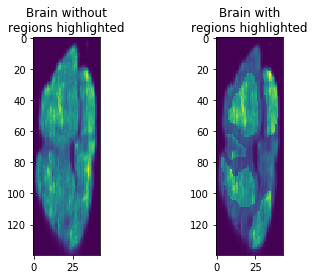

Pixel counts in regions:
left cortex: 328 pixels in region
right cortex: 283 pixels in region
middle: 152 pixels in region
left caudoputamen: 417 pixels in region
right caudoputamen: 532 pixels in region

Total pixels in image: 6020


In [4]:
# Get the regions from the labeled data file
region_count = int(data["ROIcount"])
regions = [np.array([x for x in f[data["ROI"][1,i]]]) for i in range(region_count)]

# Display the brain by displaying abundances at the m/z value that maximizes
# the abundance at a pixel within the body of the brain
pixel = (20,20)
brain_image = data['img'][np.argmax(data['img'][:,pixel[0],pixel[1]]),:,:]
print("Brain images at m/z value of",
        data["imgZ"][0][np.argmax(data['img'][:,pixel[0],pixel[1]])])
plt.subplot(121).imshow(brain_image)
plt.subplot(121).set_title("Brain without\nregions highlighted")
plt.subplot(122).imshow(brain_image + np.multiply(brain_image, sum(regions)))
plt.subplot(122).set_title("Brain with\nregions highlighted")
plt.show()

# Initialize containers for the region names and assigned colors
region_names = []
colors = ['k', 'r', 'y', 'g', 'b']

# Determine region names and amount of pixels in each region
print("Pixel counts in regions:")
for i in range(region_count):
    region_names.append(''.join([chr(x[0]) for x in f[data["ROI"][0,i]]]))
    print(region_names[-1], end=": ")
    print(sum(sum(regions[i])), "pixels in region")

# Output the total amount of pixels in the image
shape = data["img"].shape
print("\nTotal pixels in image:", shape[1]*shape[2])

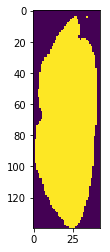

In [5]:
CUTOFF = 7300
plt.imshow(brain_image > CUTOFF)

In [6]:
xSize, ySize, zSize= data['img'].shape
n = 0
image_filter = (brain_image > CUTOFF)
region_pixel_counts = [0 for i in range(len(regions) + 1)]
region_averages = [np.zeros(xSize) for i in range(len(regions) + 1)]
overall_average = np.zeros(xSize)

for i in range(ySize):
    for j in range(zSize):
        if image_filter[i,j]:
            spectrum = data['img'][:,i,j]
            in_region = False
            for r in range(len(regions)):
                if regions[r][i,j] > 0:
                    in_region = True
                    region_pixel_counts[r] += 1
                    region_averages[r] += spectrum
                    break
            if not in_region:
                region_pixel_counts[-1] += 1
                region_averages[-1] += spectrum
            overall_average += spectrum
        
        if n % 100 == 0:
            print("Finished reading", n, "out of", ySize*zSize, "pixels", end="\r")

        n += 1

for r in range(len(regions) + 1):
    region_averages[r] /= region_pixel_counts[r]
overall_average /= sum(region_pixel_counts)
        
region_pixel_counts

[328, 283, 152, 417, 532, 2263]

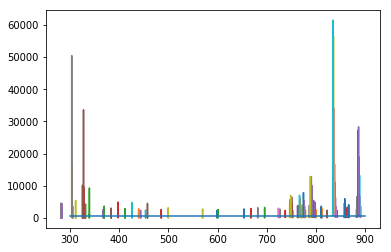

In [7]:
census_maxima = set([])
imgZ = data["imgZ"][0]
region_names.append("brain other")
MINIMUM_INTENSITY = 500
MAXIMUM_PEAK_COUNT = 500
DISPLAY_PEAK_COUNT = 100

spectrum = overall_average
assert len(spectrum) == xSize
maxima = argrelmax(spectrum)[0]
maxima = maxima[spectrum[maxima] > MINIMUM_INTENSITY]
sort = np.argsort(spectrum[maxima])
for s in maxima[sort[-DISPLAY_PEAK_COUNT:]]:
    indices = list(range(s-20, s+20))
    plt.plot([imgZ[i] for i in indices],
            [spectrum[i] for i in indices])
plt.plot(np.linspace(300, 900, 1000),
        [spectrum[maxima[sort[-MAXIMUM_PEAK_COUNT - 1]]]
        for i in range(1000)])
plt.show()
sort = sort[-MAXIMUM_PEAK_COUNT:]
maxima = maxima[sort]
census_maxima = census_maxima.union(set(maxima))

In [8]:
print(len(census_maxima))
maxima_list = np.array(sorted(census_maxima))

500


In [9]:
maxima_values = np.array([imgZ[m] for m in maxima_list])
labels = np.array([None]*n)
numbered_labels = np.array([-1]*n)

In [10]:
spectra = np.zeros((n, len(maxima_list)))
s = 0

for i in range(ySize):
    for j in range(zSize):
        spectra[s] = data['img'][:,i,j][maxima_list]
        labeled = False
        for r in range(region_count):
            if regions[r][i,j] == 1:
                labels[s] = region_names[r]
                numbered_labels[s] = r
                labeled = True
        if not labeled:
            labels[s] = ("brain other" if brain_image[i,j] > CUTOFF else "not brain")
            numbered_labels[s] = (5 if brain_image[i,j] > CUTOFF else 6)
        
        if s % 100 == 0:
            print("Finished reading", s, "out of", ySize*zSize, "rows", end="\r")
            
        s += 1

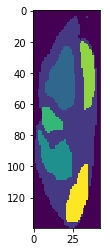

In [11]:
plt.imshow(6 - numbered_labels.reshape(ySize, zSize))

In [12]:
labels[labels == 'right caudoputamen'] = 'caudoputamen'
labels[labels == 'left caudoputamen'] = 'caudoputamen'
labels[labels == 'right cortex'] = 'cortex'
labels[labels == 'left cortex'] = 'cortex'

spectra_ = np.hstack((spectra, np.array([list(range(0, spectra.shape[0]))]).T))
X = spectra_[labels != "not brain"]
y = labels[labels != "not brain"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.70,
        random_state=1)

In [13]:
solver = 'newton-cg'
clf = LogisticRegression(solver=solver,
        multi_class='multinomial').fit(x_train, y_train)
prediction = clf.predict(x_test)
mistakes = len(y_test[prediction != y_test])
print('Using the', solver, 'solver, there were', mistakes, 'mistakes',
     'out of', len(y_test), 'data points.')

Using the newton-cg solver, there were 324 mistakes out of 2783 data points.


In [14]:
importants = {}
weight = clf.coef_[:,:-1]
for i in range(len(clf.coef_)):
    sort = np.argsort(weight[i])[:10]
    important = maxima_list[sort]
    importants[clf.classes_[i]] = important
importants

{'brain other': array([54800, 31733, 55178, 45584, 43611, 53899, 47006, 55349, 36767,
        51765]),
 'caudoputamen': array([62791, 61405, 60543, 34305, 32134, 33143, 28727, 48956, 59782,
        60053]),
 'cortex': array([58180, 46432, 58124, 58291, 58458, 37205, 44538, 44669, 60240,
        62951]),
 'middle': array([60325, 26257, 52661, 22109, 58899, 37358, 57845, 24843, 60379,
        54251])}

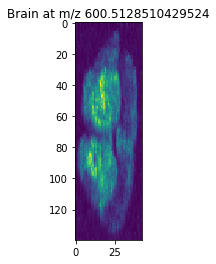

In [15]:
viewing_index = importants['cortex'][1]
brain_image = data['img'][viewing_index,:,:]
plt.imshow(brain_image)
plt.title("Brain at m/z " + str(imgZ[viewing_index]))
plt.show()

brain other
738.0146251275623
393.27209753540393
744.5602128093084
587.3690175054722
557.3508055804117
722.5291195870341
609.4922874100893
747.5308062416586
459.3256479407578
686.507025668787
caudoputamen
882.5421599862772
856.548750183187
840.5785444391925
426.3801245985972
398.34591560090684
411.2565927327942
356.2732439402113
640.4951051825448
826.6044655263752
831.5673508265272
cortex
797.5701218394358
600.5128510429524
796.5645783755457
799.5651273188421
802.5713172047307
465.3152574368055
571.3565837607437
573.3498424824079
835.000586335926
885.5678580015775
middle
836.5634860935406
327.23963273189065
701.5193967766007
281.25840148053334
810.5369349539859
467.4166633910036
791.5642695001283
311.17422666444236
837.5571462095756
728.5594070902765


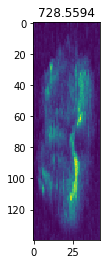

In [16]:
for key in importants:
    print(key)
    for index in importants[key]:
        brain_image = data['img'][index,:,:]
        plt.imshow(brain_image)
        print(imgZ[index])
        plt.title(str(imgZ[index])[:8])
        plt.savefig("brain_" + str(imgZ[index])[:7].replace('.', '_'),
                bbox_inches='tight')

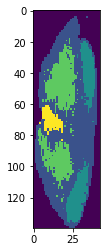

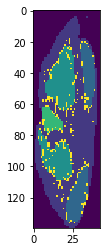

In [17]:
str_to_num = {'brain other':1, 'cortex':2, 'caudoputamen':3, "middle":4}
image = np.zeros(spectra.shape[0])
last = int(spectra.shape[1])
for i in range(len(y_train)):
    image[int(x_train[i,last])] = str_to_num[y_train[i]]
for i in range(len(y_test)):
    image[int(x_test[i,last])] = str_to_num[prediction[i]]
plt.imshow(image.reshape(shape[1:]))
plt.show()
for i in x_test[prediction != y_test, spectra.shape[1]].astype(int):
    image[i] = 6
plt.imshow(image.reshape(shape[1:]))
plt.show()

In [18]:
important = {}
TRIAL_COUNT = 100

for j in range(TRIAL_COUNT):
    clf = RandomForestClassifier(n_estimators=100).fit(x_train, y_train)
    prediction = clf.predict(x_test)
    mistakes = len(y_test[prediction != y_test])

    weights = clf.feature_importances_[:-1]
    indices = maxima_list[np.argsort(weights)]
    for i in range(len(indices[:100])):
        if indices[i] in important:
            important[indices[i]].append(i)
        else:
            important[indices[i]] = [i]
    
    print("Finished", j+1, "out of", TRIAL_COUNT, "trials", end="\r")
            
    j += 1

In [19]:
sort = np.argsort([len(important[k]) for k in important])
sorted_keys = np.array(list(reversed(list(important.keys()))))[sort]

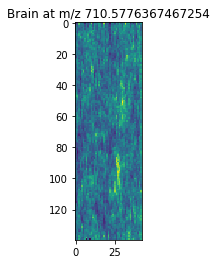

In [20]:
viewing_index = sorted_keys[9]
brain_image = data['img'][viewing_index,:,:]
plt.subplot(121).imshow(brain_image)
plt.subplot(121).set_title("Brain at m/z " + str(imgZ[viewing_index]))
plt.show()

833.8982428223852
888.0110972898676
887.2152545007433
818.5600856908843
837.0602424266515
863.5806380900875
483.3071636959443
742.5484403163007
479.2887482525715
710.5776367467254


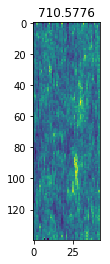

In [21]:
for index in sorted_keys[:10]:
    brain_image = data['img'][index,:,:]
    plt.imshow(brain_image)
    print(imgZ[index])
    plt.title(str(imgZ[index])[:8])
    plt.savefig("brain_" + str(imgZ[index])[:7].replace('.', '_'),
            bbox_inches='tight')

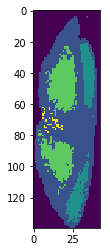

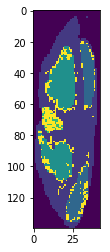

In [22]:
str_to_num = {'brain other':1, 'cortex':2, 'caudoputamen':3, "middle":4}
image = np.zeros(spectra.shape[0])
last = int(spectra.shape[1])
for i in range(len(y_train)):
    image[int(x_train[i,last])] = str_to_num[y_train[i]]
for i in range(len(y_test)):
    image[int(x_test[i,last])] = str_to_num[prediction[i]]
plt.imshow(image.reshape(shape[1:]))
plt.show()
for i in x_test[prediction != y_test, spectra.shape[1]].astype(int):
    image[i] = 6
plt.imshow(image.reshape(shape[1:]))
plt.show()

In [23]:
model = XGBClassifier()
model.fit(x_train[:,:-1], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [24]:
prediction = model.predict(x_test[:,:-1])
mistakes = len(y_test[prediction != y_test])
print('Using XGBoost, there were', mistakes, 'mistakes',
     'out of', len(y_test), 'data points.')

Using XGBoost, there were 388 mistakes out of 2783 data points.


In [25]:
important = model.feature_importances_
sort = np.array(list(reversed(list(np.argsort(important)))))
sorted_keys = maxima_list[sort]
# my_array = maxima_list[sort]
# imgZ[my_array]
# sorted_keys = np.array(list(reversed(list(important.keys()))))[sort]

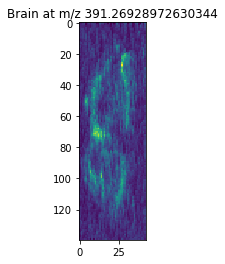

In [26]:
viewing_index = sorted_keys[0]
brain_image = data['img'][viewing_index,:,:]
plt.subplot(121).imshow(brain_image)
plt.subplot(121).set_title("Brain at m/z " + str(imgZ[viewing_index]))
plt.show()

391.26928972630344
722.5291195870341
599.5002165450752
598.5039960082088
600.5128510429524
767.5563899162112
909.5761732368557
327.23963273189065
791.5642695001283
746.5225737155532


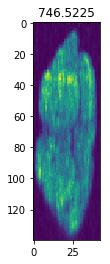

In [27]:
for index in sorted_keys[:10]:
    brain_image = data['img'][index,:,:]
    plt.imshow(brain_image)
    print(imgZ[index])
    plt.title(str(imgZ[index])[:8])
    plt.savefig("brain_" + str(imgZ[index])[:7].replace('.', '_'),
            bbox_inches='tight')

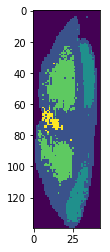

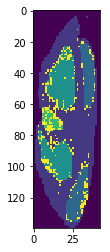

In [28]:
str_to_num = {'brain other':1, 'cortex':2, 'caudoputamen':3, "middle":4}
image = np.zeros(spectra.shape[0])
last = int(spectra.shape[1])
for i in range(len(y_train)):
    image[int(x_train[i,last])] = str_to_num[y_train[i]]
for i in range(len(y_test)):
    image[int(x_test[i,last])] = str_to_num[prediction[i]]
plt.imshow(image.reshape(shape[1:]))
plt.show()
for i in x_test[prediction != y_test, spectra.shape[1]].astype(int):
    image[i] = 6
plt.imshow(image.reshape(shape[1:]))
plt.show()

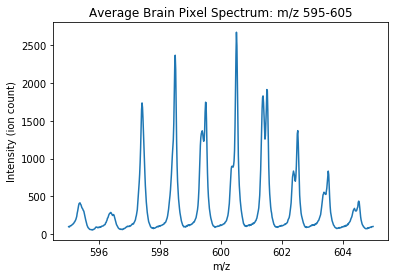

In [29]:
mz_filter = imgZ >= 595
mz_filter2 = imgZ[mz_filter] <= 605
plt.plot(imgZ[mz_filter][mz_filter2],
        overall_average[mz_filter][mz_filter2])
plt.title("Average Brain Pixel Spectrum: m/z 595-605")
plt.xlabel("m/z")
plt.ylabel("Intensity (ion count)")
plt.show()

In [71]:
pca = PCA(n_components=1).fit(X)
print("Explained variance:", str(sum(pca.explained_variance_ratio_)*100)[:7] + "%")
sort = np.array(list(reversed(list(np.argsort(abs(pca.components_[0][:-1] / overall_average[maxima_list]))))))
sorted_keys = maxima_list[sort]

Explained variance: 78.8222%


910.5738921410051
866.5362378796341
865.5255282265329
909.5761732368557
884.5650220202358
883.5627541927024
858.5416163149337
881.5410391864533
859.548241074859
836.5634860935406


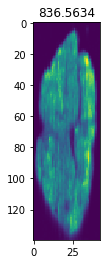

In [72]:
for index in sorted_keys[:10]:
    brain_image = data['img'][index,:,:]
    plt.imshow(brain_image)
    print(imgZ[index])
    plt.title(str(imgZ[index])[:8])
    plt.savefig("brain_" + str(imgZ[index])[:7].replace('.', '_'),
            bbox_inches='tight')

858.5416163149337


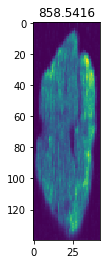

In [68]:
index = sorted_keys[6]
brain_image = data['img'][index,:,:]
plt.imshow(brain_image)
print(imgZ[index])
plt.title(str(imgZ[index])[:8])
plt.savefig("brain_" + str(imgZ[index])[:7].replace('.', '_'),
        bbox_inches='tight')

In [80]:
pca = PCA(n_components=90).fit(X)
print("Explained variance:", str(sum(pca.explained_variance_ratio_)*100)[:7] + "%")
pca.components_[0:1,:-1] / overall_average[maxima_list]
# sort = np.array(list(reversed(list(np.argsort(pca.components_[0:1,:-1] / overall_average[maxima_list])))))
# sorted_keys = maxima_list[sort]

Explained variance: 99.0127%


array([[-1.48932163e-06, -1.78499930e-06, -3.66722599e-06,
         2.11816981e-06,  3.06898642e-06,  1.39090242e-06,
         2.80616338e-06, -1.73639038e-06, -2.19776787e-07,
        -2.79106449e-08,  8.22533575e-07,  7.08740394e-06,
         7.32897669e-06,  6.76695015e-06,  6.03182247e-06,
        -8.77834466e-07,  1.70552530e-06, -7.39395891e-07,
         1.98935893e-06,  2.59615010e-07, -4.88796624e-07,
         3.52007803e-07, -1.65371249e-07,  8.66864660e-07,
        -2.83365898e-07,  4.90424548e-06, -1.45143507e-06,
        -9.83948654e-07,  2.73382679e-07,  4.41213386e-07,
         7.81225250e-06,  7.73999028e-06,  5.97503018e-06,
         4.86588375e-06,  4.77627586e-06,  4.91524173e-06,
         3.44746045e-06,  3.83527833e-06, -1.06429261e-06,
         7.82082181e-07, -1.04504971e-06,  8.08756657e-07,
        -2.62655632e-06,  1.58337825e-06, -7.52969670e-07,
         1.29663890e-07,  1.18452611e-06, -2.71672784e-07,
        -7.08628238e-07, -1.11825955e-06,  8.89236631e-0

In [74]:
# Do a Scree plot
pca.explained_variance_ratio_

array([0.78822298, 0.07684722])